In [ ]:
!pip install ydata-profiling

In [40]:
import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport

In [41]:
listings = pd.read_csv("http://data.insideairbnb.com/canada/on/toronto/2024-01-08/data/listings.csv.gz")

In [ ]:
listings.head()

In [ ]:
listings.info()

In [ ]:
listings_profile = ProfileReport(listings, title="Listings Profile Report")
listings_profile.to_file("Listings_Profile.html")

In [51]:
#missing values check
missing_values = listings.isna().sum()
missing_percentage = (listings.isna().mean() * 100).round(2)
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Filter out columns with zero missing values and sort
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

print("Missing values count and percentage in each column (descending order):")
print(missing_df)

Missing values count and percentage in each column (descending order):
                              Missing Values  Percentage
description                            20386      100.00
bathrooms                              20386      100.00
calendar_updated                       20386      100.00
neighbourhood_group_cleansed           20386      100.00
bedrooms                               20382       99.98
host_neighbourhood                     11819       57.98
license                                10930       53.62
host_about                             10683       52.40
neighborhood_overview                   9049       44.39
neighbourhood                           9048       44.38
host_response_time                      6732       33.02
host_response_rate                      6732       33.02
host_acceptance_rate                    5425       26.61
review_scores_location                  5259       25.80
reviews_per_month                       5258       25.79
last_review      

There are 4 attributes which are completely missing, so we will remove those. also bedrooms is almost completely missing, so we will remove that as well

In [11]:
# drop column with all missing values
listings.drop(['description', 'bathrooms', 'calendar_updated', 'neighbourhood_group_cleansed'], axis=1, inplace=True)
listings.drop('bedrooms', axis=1, inplace=True) #bedrooms almost all missing, also drop

After an initial look at the data, we can see that the data types used for ID is numbers, which results in mathematical calculation on thes attributes - that is incorrect. We will chnage the datatypes so that our further analysis will be beneficial.

In [12]:
#since each id is unique, using 'category' type not beneificil, so str used
listings['id']=listings['id'].astype('str')

#using 'category' type for host_id is beneficial, since 34% are repeated it will make analysis more stratghtforward and will have potential memory savings
listings['host_id'] = listings['host_id'].astype('category')

# scrape id is also an identifier, not a number that needs calculations on it
listings['scrape_id'] = listings['scrape_id'].astype('category')

There are other attributes whose data type need to be corrected

In [13]:
# host response rate is a percentage, it seems to be read as text so lets fix that
print(listings['host_response_rate'].head())

#convert host response rate to percentage(float)
listings['host_response_rate'] = listings['host_response_rate'].str.replace('%','').astype(float)
print(listings['host_response_rate'].head())

0     98%
1     NaN
2     83%
3     80%
4    100%
Name: host_response_rate, dtype: object
0     98.0
1      NaN
2     83.0
3     80.0
4    100.0
Name: host_response_rate, dtype: float64


In [14]:
# host acceptance rate is also a percentage, lets fix that
print(listings['host_acceptance_rate'].head())

# convert to percentage(float)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace('%','').astype(float)
print(listings['host_acceptance_rate'].head())

0    100%
1     NaN
2     95%
3     88%
4     94%
Name: host_acceptance_rate, dtype: object
0    100.0
1      NaN
2     95.0
3     88.0
4     94.0
Name: host_acceptance_rate, dtype: float64


Property type is being read as text, but could benefit from being categorical (like room type)

---



In [15]:
print(listings['property_type'].head())
listings['property_type'] = listings['property_type'].astype('category') #it is currently text, but

0                 Private room in home
1                                 Boat
2            Private room in townhouse
3    Private room in bed and breakfast
4                 Private room in home
Name: property_type, dtype: object


The price attribute is being read as text, lets change that

In [16]:
print(listings['price'].head()) #currently text, should be a number ($price)

# Remove currency symbols and commas, then convert to float
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

0     $45.00
1    $180.00
2     $34.00
3     $45.00
4     $63.00
Name: price, dtype: object


There are some url columns, which are not useful for us. We will use the listing id as the identifier, so we can safely remove the url columns.

In [17]:
listings.drop('listing_url', axis=1, inplace=True)  # each entry is distinct, meaning each lisitng has a specific url

listings.drop('picture_url', axis=1, inplace=True) # there are 96.8% unique entries - maybe some lisings use the same picture

listings.drop('host_url', axis=1, inplace=True) # these links take us to the hosts airbnb profile - not useful we will use the host id to idetify host

listings.drop('host_thumbnail_url', axis=1, inplace=True) # this links to a thumbnail image for the listings - not usful

listings.drop('host_picture_url', axis=1, inplace=True) # this links to the image of the host

There are other attributes that are added by inside airbnb regarding the scraping of the data, which are not beneficial for us

In [18]:
listings.drop('scrape_id', axis=1, inplace=True) #the scrape_id is the id used by inside airbnb to scrape the data. we don't need this

listings.drop('last_scraped', axis=1, inplace=True) #this indicates the date it was last scraped. there are 3 dates, all 1 day apart. this is not beneficial for us

listings.drop('source', axis=1, inplace=True) # this tells us where the source of the scrape is, again not beneficial for us


It looks like there are two neighbourhood attributes remaining, lets compare them and see if they are both necessary

In [19]:
#since neighbourhood has many missing values, we will filter
#to include entries where both neighborhood and neighbourhodd_cleansed have data

filtered_neighbourhood = listings.dropna(subset=['neighbourhood', 'neighbourhood_cleansed'])
print(filtered_neighbourhood['neighbourhood'].head())
print(filtered_neighbourhood['neighbourhood_cleansed'].head())
#print(filtered_neighbourhood.head())

print("original df size:", listings.shape)
print("filtered df size:", filtered_neighbourhood.shape)

8     Toronto, Ontario, Canada
13    Toronto, Ontario, Canada
18    Toronto, Ontario, Canada
21    Toronto, Ontario, Canada
26    Toronto, Ontario, Canada
Name: neighbourhood, dtype: object
8                      Morningside
13    Agincourt South-Malvern West
18                         Malvern
21                       Guildwood
26               High Park-Swansea
Name: neighbourhood_cleansed, dtype: object
original df size: (20386, 62)
filtered df size: (11338, 62)


It appears that the two attributes are not so similar. Lets take a closer look at them

In [ ]:
# compare the 2 - check if the valeus in neighbourhood and neighbourhood_cleansed are the same
neighbourhood_comparison = filtered_neighbourhood[['neighbourhood','neighbourhood_cleansed']].copy()
neighbourhood_comparison["Are_Values_same"] = (filtered_neighbourhood['neighbourhood'] == filtered_neighbourhood['neighbourhood_cleansed'])

print(neighbourhood_comparison.head())

               neighbourhood        neighbourhood_cleansed  Are_Values_same
8   Toronto, Ontario, Canada                   Morningside            False
13  Toronto, Ontario, Canada  Agincourt South-Malvern West            False
18  Toronto, Ontario, Canada                       Malvern            False
21  Toronto, Ontario, Canada                     Guildwood            False
26  Toronto, Ontario, Canada             High Park-Swansea            False


It appears that the 'neighbourhood' column has a mix of broad and specific geographical identifiers, with variations in formatting and detail

In [ ]:
# Get unique values in the 'neighbourhood' column
unique_neighbourhoods = listings['neighbourhood'].unique()
print(unique_neighbourhoods)

[nan 'Toronto, Ontario, Canada' 'Old Toronto, Ontario, Canada'
 'North York, Ontario, Canada' 'Etobicoke, Ontario, Canada'
 'East York, Ontario, Canada' 'Scarborough, Ontario, Canada'
 'Toronto , Ontario, Canada' 'Markham, Ontario, Canada'
 'Toronto, Ontario, CA, Ontario, Canada' 'Vaughan, Ontario, Canada'
 'Downtown Toronto, Ontario, Canada' 'Toronto, ONOntario, Canada'
 'Toronto, ONTARIO, Canada' 'North York, ONOntario, Canada'
 'Toronto, Canada' '多伦多, Ontario, Canada' 'TORONTO, Ontario, Canada'
 'Toronto, 1, Canada' ' Toronto, Ontario, Canada' 'Ontario, Canada'
 'York, Ontario, Canada' 'NorthYork, Ontario, Canada'
 'Toronto, ON,, Canada' 'Canada' 'Ontario, Toronto, Canada'
 'toronto, ontario,, Ontario, Canada' 'Toronto,, Ontario, Canada'
 'Etobicoke , Ontario, Canada' ' North York, Ontario, Canada'
 'Toronto, Ontario, , Canada' 'Toronto , ON , Canada'
 'West Toronto, Ontario, Canada' 'North york - Toronto , Ontario, Canada'
 'Thornhill, Ontario, Canada' 'toronto, Ontario, Canada'
 '

The 'neighbourhood_cleansed' attribute represents a comprehensive set of unique neighborhood names. These names appear to be standardized and offer a precise breakdown of the various areas within and around Toronto

In [ ]:
# Get unique values in the neighbourhood_cleansed column
unique_neighbourhoods_cleansed = listings['neighbourhood_cleansed'].unique()
print(unique_neighbourhoods_cleansed)

['Hillcrest Village' 'Waterfront Communities-The Island' 'Rexdale-Kipling'
 "Tam O'Shanter-Sullivan" 'Rouge' 'Steeles' 'West Humber-Clairville'
 'Morningside' 'Bayview Village' 'Agincourt South-Malvern West'
 'Downsview-Roding-CFB' 'Centennial Scarborough' 'Don Valley Village'
 'Birchcliffe-Cliffside' 'Malvern' 'Flemingdon Park' 'Guildwood'
 'Parkwoods-Donalda' 'Pleasant View' 'High Park-Swansea'
 'Wexford/Maryvale' 'Henry Farm' 'Pelmo Park-Humberlea'
 'Mount Olive-Silverstone-Jamestown' "O'Connor-Parkview"
 'Danforth East York' 'Banbury-Don Mills' 'Yorkdale-Glen Park' 'Bendale'
 'Stonegate-Queensway' 'St.Andrew-Windfields' 'Old East York'
 'Leaside-Bennington' 'New Toronto' 'East End-Danforth'
 'Clairlea-Birchmount' 'Mimico (includes Humber Bay Shores)'
 'Clanton Park' 'Black Creek' 'West Hill' 'Woodbine-Lumsden' 'Weston'
 'Lawrence Park South' 'Lawrence Park North' 'Mount Dennis'
 'Brookhaven-Amesbury' 'Westminster-Branson' 'Bathurst Manor'
 'Beechborough-Greenbrook' 'Rustic' 'Oakrid

In [17]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20386 entries, 0 to 20385
Data columns (total 62 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            20386 non-null  object  
 1   name                                          20386 non-null  object  
 2   neighborhood_overview                         11337 non-null  object  
 3   host_id                                       20386 non-null  category
 4   host_name                                     20384 non-null  object  
 5   host_since                                    20384 non-null  object  
 6   host_location                                 15288 non-null  object  
 7   host_about                                    9703 non-null   object  
 8   host_response_time                            13654 non-null  object  
 9   host_response_rate                            1365

In [20]:
#summary statistics for all attributes

from tabulate import tabulate
listings_summary_statistics = listings.describe(include='all').T
print(tabulate(listings_summary_statistics, headers='keys', tablefmt='psql', floatfmt=".2f"))

+----------------------------------------------+----------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------+--------+--------+--------+--------+---------+----------+
|                                              |    count |   unique | top                                                                                                                                                                                                

Here we explore the review scores

In [25]:
# List of review score columns
review_columns = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

# Select only the review score columns from the dataset
reviews_data = listings[review_columns]

# Calculate summary statistics for the review score attributes
reviews_summary_statistics = reviews_data.describe().T

print(tabulate(reviews_summary_statistics, headers='keys', tablefmt='psql', floatfmt=".2f"))

+-----------------------------+----------+--------+-------+-------+-------+-------+-------+-------+
|                             |    count |   mean |   std |   min |   25% |   50% |   75% |   max |
|-----------------------------+----------+--------+-------+-------+-------+-------+-------+-------|
| review_scores_rating        | 15132.00 |   4.77 |  0.41 |  1.00 |  4.71 |  4.89 |  5.00 |  5.00 |
| review_scores_accuracy      | 15129.00 |   4.80 |  0.39 |  0.00 |  4.77 |  4.92 |  5.00 |  5.00 |
| review_scores_cleanliness   | 15131.00 |   4.73 |  0.45 |  0.00 |  4.67 |  4.87 |  5.00 |  5.00 |
| review_scores_checkin       | 15128.00 |   4.85 |  0.35 |  0.00 |  4.84 |  4.96 |  5.00 |  5.00 |
| review_scores_communication | 15129.00 |   4.86 |  0.35 |  1.00 |  4.87 |  4.98 |  5.00 |  5.00 |
| review_scores_location      | 15127.00 |   4.83 |  0.31 |  1.00 |  4.78 |  4.92 |  5.00 |  5.00 |
| review_scores_value         | 15129.00 |   4.69 |  0.44 |  0.00 |  4.61 |  4.79 |  4.95 |  5.00 |


Lets do a geospatial analysis now

In [35]:
# Plotting Listings on a Map

import folium

# Create a map centered around an average location in Toronto
toronto_map = folium.Map(location=[listings['latitude'].mean(), listings['longitude'].mean()], zoom_start=12)

# Sample a fraction of listings to avoid overloading the map
for idx, row in listings.sample(frac=0.1).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=1,
                        color='blue',
                        fill=True).add_to(toronto_map)

toronto_map

Now lets explore correlations

In [28]:
!pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-34-1fdfca6f46f1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = listings.corr()


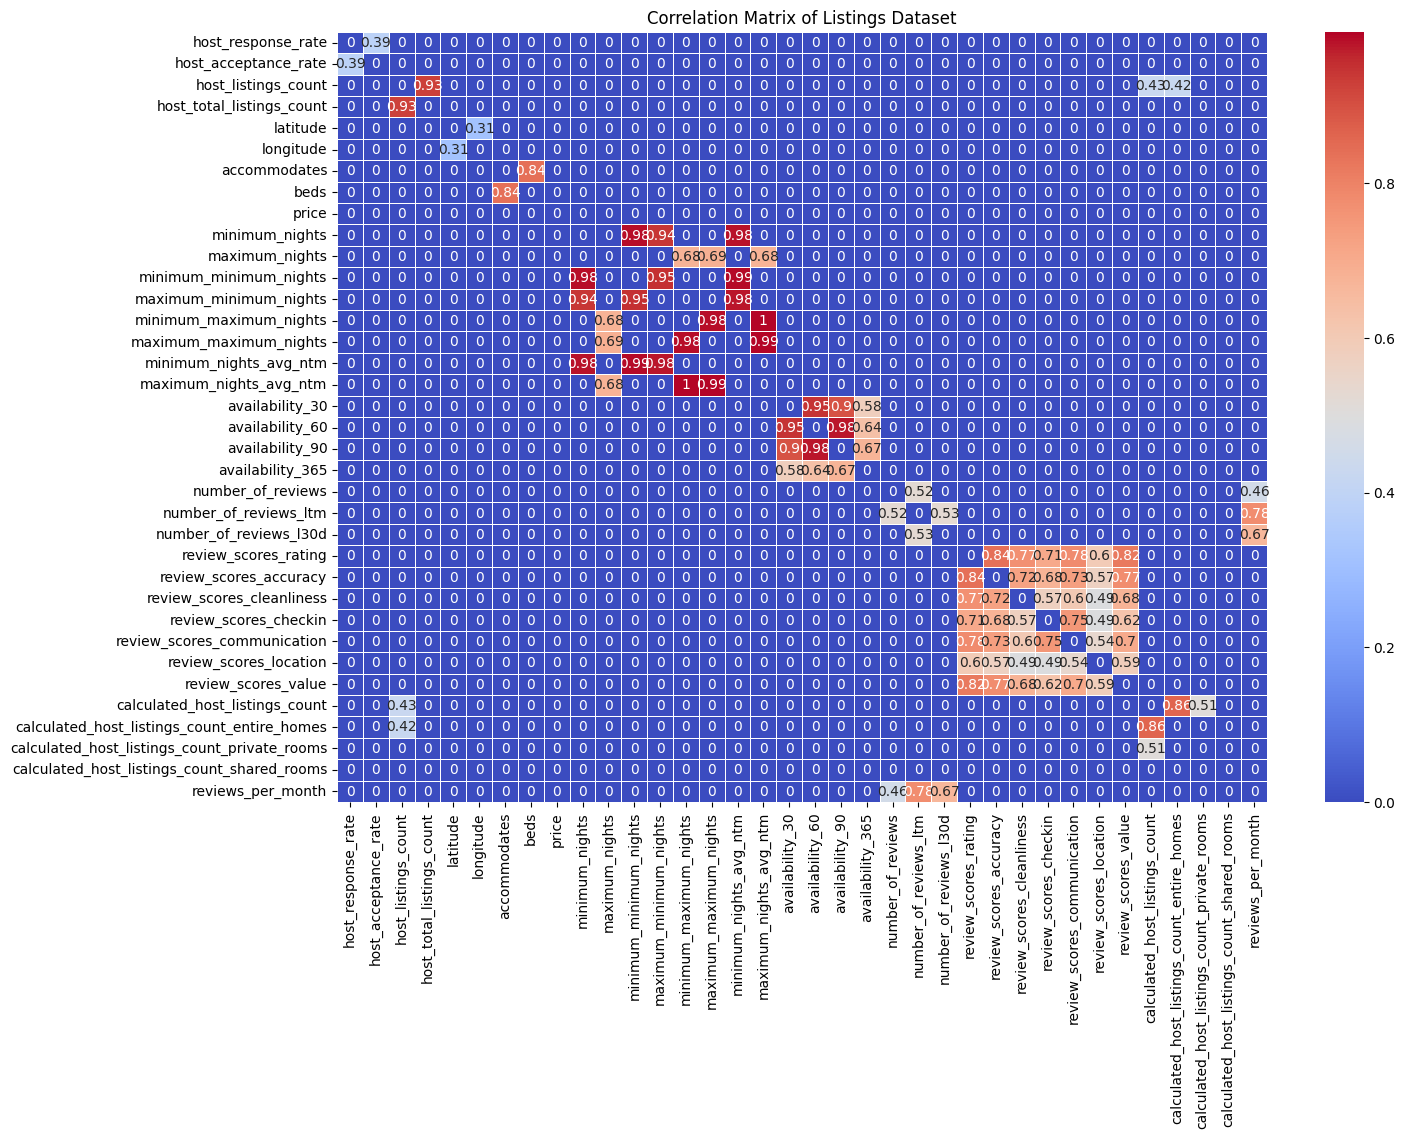

In [34]:
# Calculate the correlation matrix
correlation_matrix = listings.corr()

# Set the diagonal to NaN so these values won't be colored in the heatmap
np.fill_diagonal(correlation_matrix.values, np.nan)

# Apply a threshold: only keep values where the absolute value is greater than 0.3
filtered_corr = correlation_matrix[abs(correlation_matrix) > 0.3].fillna(0)  # Replace non-significant correlations with 0

# Create a heatmap
plt.figure(figsize=(15, 10))  # Adjust the size as needed
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Listings Dataset')
plt.show()

**look into amenities?**
it appears that amenities attribute is behaving strangely, lets explore it

In [ ]:
print(listings['amenities'].head())
print(listings['amenities'].sample(5))

0    []
1    []
2    []
3    []
4    []
Name: amenities, dtype: object
19140    []
16348    []
3347     []
19829    []
1881     []
Name: amenities, dtype: object


In [ ]:
# Check for unique values or the number of non-empty lists
non_empty_amenities = listings['amenities'].apply(lambda x: x != '[]').sum()
print(f"Number of non-empty amenities lists: {non_empty_amenities}")

Number of non-empty amenities lists: 0
